 Applying Transfer Learning on tf_flowers Dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_hub'

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [6]:
data_splitting = ["train[:70%]", "train[70%:]"]

dataset, dataset_info = tfds.load("tf_flowers",
                                  split=data_splitting,
                                  as_supervised=True,
                                  with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
train_set, valid_set = dataset
print(dataset_info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [8]:
num_classes = dataset_info.features["label"].num_classes

number_training_exps = 0
number_valid_exps = 0

for i in train_set:
    number_training_exps += 1

for i in valid_set:
    number_valid_exps += 1

print(f"Number of Classes {num_classes}")
print(f"Total Number of training examples: {number_training_exps}")
print(f"Total Number of validation examples: {number_valid_exps}")

Number of Classes 5
Total Number of training examples: 2569
Total Number of validation examples: 1101


In [9]:
# different images shape
for i, exp in enumerate(train_set.take(10)):
    print(f"different image shape: {exp[0].shape}")

different image shape: (333, 500, 3)
different image shape: (212, 320, 3)
different image shape: (240, 320, 3)
different image shape: (240, 320, 3)
different image shape: (317, 500, 3)
different image shape: (212, 320, 3)
different image shape: (240, 240, 3)
different image shape: (333, 500, 3)
different image shape: (240, 320, 3)
different image shape: (240, 320, 3)


In [10]:
# Resizing to fit in the pretrained model (transfer learning)
img_size = 224

def resizing(image, label):
    image = tf.image.resize(image, (img_size, img_size))/255.0
    return image, label

batch_size = 32

batched_training_set = train_set.shuffle(number_training_exps//4).map(resizing).batch(batch_size).prefetch(1) # Batching and mapping to the resizing function
batched_valid_set = valid_set.map(resizing).batch(batch_size).prefetch(1)

In [11]:
# Mobile_net with tensorflow hub
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

extracting = hub.KerasLayer(mobile_net_url, input_shape=(img_size, img_size, 3))

In [12]:
# freezing the variables..
extracting.trainable = False


In [13]:
# Model time..
model = tf.keras.Sequential([
                             extracting,
                             tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["accuracy"])

In [15]:
epochs = 10

history = model.fit(batched_training_set,
                    validation_data=batched_valid_set,
                    epochs=epochs)

Epoch 1/10
81/81 [==============================] - 37s 53ms/step - loss: 1.0646 - accuracy: 0.5875 - val_loss: 0.4433 - val_accuracy: 0.8574
Epoch 2/10
81/81 [==============================] - 3s 43ms/step - loss: 0.3859 - accuracy: 0.8711 - val_loss: 0.3569 - val_accuracy: 0.8738
Epoch 3/10
81/81 [==============================] - 3s 43ms/step - loss: 0.3075 - accuracy: 0.9044 - val_loss: 0.3350 - val_accuracy: 0.8828
Epoch 4/10
81/81 [==============================] - 4s 44ms/step - loss: 0.2454 - accuracy: 0.9266 - val_loss: 0.3099 - val_accuracy: 0.8965
Epoch 5/10
81/81 [==============================] - 4s 43ms/step - loss: 0.2193 - accuracy: 0.9355 - val_loss: 0.3051 - val_accuracy: 0.8955
Epoch 6/10
81/81 [==============================] - 4s 43ms/step - loss: 0.1889 - accuracy: 0.9515 - val_loss: 0.2866 - val_accuracy: 0.8974
Epoch 7/10
81/81 [==============================] - 3s 43ms/step - loss: 0.1611 - accuracy: 0.9607 - val_loss: 0.2915 - val_accuracy: 0.9028
Epoch 8/10
8

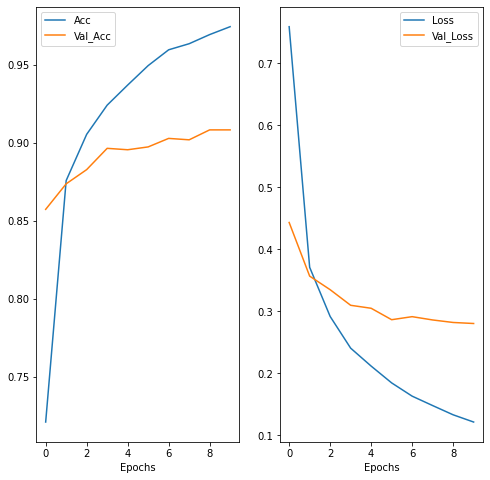

In [16]:
# 90% validation accuracy 
# now we need to plot..
epoch_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, history.history["accuracy"], label="Acc")
plt.plot(epoch_range, history.history["val_accuracy"], label="Val_Acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, history.history["loss"], label="Loss")
plt.plot(epoch_range, history.history["val_loss"], label="Val_Loss")
plt.xlabel("Epochs")
plt.legend()

In [19]:
# predictions...
class_names = dataset_info.features['label'].names
img, lbl = next(iter(batched_training_set))

img = img.numpy()
lbl = lbl.numpy()

predicted_batch = model.predict(img)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_lbls = np.argmax(predicted_batch, axis=1)


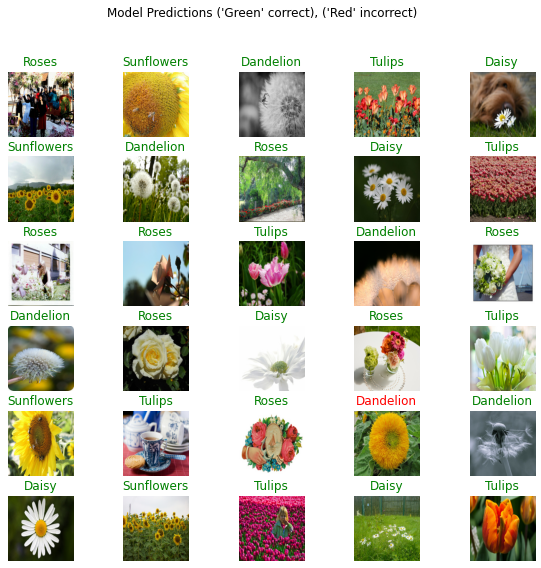

In [20]:
plt.figure(figsize=(10, 9))
class_names = np.array(class_names)
for i in range(30): 
    plt.subplot(6, 5, i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(img[i])
    color = "green" if predicted_lbls[i] == lbl[i] else "red"
    plt.title(class_names[predicted_lbls][i].title(), color=color)
    plt.axis("off")
    a_ = plt.suptitle("Model Predictions ('Green' correct), ('Red' incorrect)")